In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from tqdm import tqdm
from quetzal.model import stepmodel
from syspy.skims import skims

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Emissions modelling
## Saves emissions from passenger transport
## Needs inner- and intra-zonal passenger kilometer by mode

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

### Load results

In [3]:
sm = stepmodel.read_json(model_path + 'de_assignment')

In [4]:
# Filter unused road links
sm.road_links = sm.road_links.loc[~sm.road_links.isna().any(axis=1)]
sm.road_links.sample()

,a,b,maxspeed,length,time,"('Fz1', 'car')","('Fz2', 'car')","('Fz3', 'car')","('Fz4', 'car')","('Fz6', 'car')","('all', 'car')",geometry,lanes
index,,,,,,,,,,,,,
rl_323794,821544981,598728024,68,14,0,5.085773e+06,509708.827413,5.575273e+06,3.048694e+06,1.062909e+07,2.484854e+07,"LINESTRING (8.08293 50.12276, 8.08293 50.12264)",1


In [5]:
# Import bugfix
segments = ['Fz1', 'Fz2', 'Fz3', 'Fz4', 'Fz6', 'all']
column_dict = {"('"+seg+"', 'car')": (seg, 'car') for seg in segments}
sm.road_links = sm.road_links.rename(columns=column_dict)

In [6]:
# Calculate vehicle kilometers by demand segment
# As done in model_assignment_inner-zone
occ_dict = {'Fz1': 1.16, 'Fz2': 2.41, 'Fz3': 1.51,
            'Fz4': 1.28, 'Fz6': 2.07, 'all': 1.5} # MiD2017 data
sm.road_links['vkm'] = 0
for seg in segments:
    sm.road_links['vkm'] += sm.road_links[(seg, 'car')] * sm.road_links['length']/1000 / occ_dict[seg]
sm.road_links['vkm'] = sm.road_links['vkm'].astype(int)

In [7]:
# Create a DataFrame to map road links to a zone
road_geo = gpd.GeoDataFrame({'NUTS1': [np.nan]*len(sm.road_links)},
                            index=sm.road_links.index,
                            geometry=[shapely.geometry.Point(g.coords[0])
                                      for g in sm.road_links['geometry']],
                            crs=sm.epsg)

In [8]:
# Load zone geometries
zones = gpd.read_file("../input_static/spatial_NUTS_RG_01M_2016_4326.geojson")
zones = zones[(zones["CNTR_CODE"]=="DE") & (zones["LEVL_CODE"]==1)]

In [9]:
# Map
shapely.speedups.enable()
for _, zone in tqdm(zones.iterrows(), total=zones.shape[0]):
    road_geo.loc[road_geo['geometry'].within(zone['geometry']), 'NUTS1'] = zone['NUTS_ID']

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [01:50<00:00,  6.91s/it]


In [10]:
# Sum up vkm by region and speed limit
merged = sm.road_links.merge(road_geo['NUTS1'], left_index=True, right_index=True)
inter_car = merged.groupby(['NUTS1', 'maxspeed']).agg({'vkm': 'sum'})
inter_car

vkm
NUTS1 maxspeed              
DE1   30        1.824998e+08
      40        1.365085e+09
      50        5.469741e+09
      57        1.029513e+10
      60        5.767236e+08
...                      ...
DEG   96        5.661672e+08
      100       9.034717e+08
      120       4.187304e+08
      125       1.647155e+10
      130       4.176458e+08

[219 rows x 1 columns]

In [11]:
# Generate length for PT links if not done yet
if 'length' not in sm.loaded_links.columns:
    sm.loaded_links['length'] = skims.distance_from_geometry(
        sm.loaded_links['geometry']).astype(int)

In [12]:
# Emissions from PT are considered in the service's origin
node_dict = sm.loaded_nodes['FID'].str[:3].to_dict()
sm.loaded_links['NUTS1'] = sm.loaded_links['a'].map(node_dict)
sm.loaded_links['pkm'] = sm.loaded_links['length']/1000 * sm.loaded_links['load']
inter_pt = sm.loaded_links.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'})
inter_pt

pkm
NUTS1 route_type              
DE1   air         7.593802e+07
      bus         1.480693e+09
      coach       2.137438e+09
      ferry       0.000000e+00
      rail_long   4.224224e+09
...                        ...
DEG   bus         2.467487e+08
      coach       3.256619e+08
      rail_long   1.278140e+09
      rail_short  1.056461e+09
      subway      3.174750e+06

[100 rows x 1 columns]

In [13]:
# Load results of inner-zonal traffic
inner = pd.read_excel(output_path + 'inner_zone.xlsx', sheet_name='agg', index_col=[0,1])

In [14]:
inner = inner.rename(index={'rail': 'rail_short'})

In [15]:
# Combine results
merged['pkm'] = merged[('all', 'car')] * merged['length']/1000
merged['route_type'] = 'car'
all_pkm = merged.groupby(['NUTS1', 'route_type']).agg({'pkm': 'sum'}).append(inter_pt)
inner.index.rename(['NUTS1', 'route_type'], inplace=True)
all_pkm = all_pkm.merge(inner['pkm'], how='outer', left_index=True,
                        right_index=True, suffixes=['_inter', '_inner']).fillna(0)
all_pkm['pkm'] = all_pkm['pkm_inter'] + all_pkm['pkm_inner']

array([<AxesSubplot:ylabel='None'>], dtype=object)

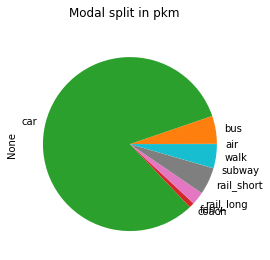

In [16]:
all_pkm['pkm'].unstack().sum(axis=0).plot.pie(subplots=True, title='Modal split in pkm')

In [17]:
# Mode shares in percent
mode_agg = {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus', 'coach': 'bus',
            'rail_long': 'rail', 'rail_short': 'rail'}
total = all_pkm['pkm'].sum()
all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/total*100

,pkm
route_type,
air,0.048279
bus,6.181221
car,81.847985
rail,7.441433
walk,4.481081


In [18]:
# Total traffic (billion pkm)
total/1e9

1348.3618247791128

In [19]:
# Mode shares in total (billion pkm)
all_pkm.rename(index=mode_agg).groupby(level=1).agg({'pkm': 'sum'})/1e9

,pkm
route_type,
air,0.650974
bus,83.345229
car,1103.606985
rail,100.337446
walk,60.421191


In [20]:
# Merge car vkm
car_vkm = inner.xs('car', level=1)[['vkm']].merge(
    inter_car.groupby(level=0).sum()['vkm'], how='outer', left_index=True,
    right_index=True, suffixes=['_inner', '_inter']).fillna(0)
car_vkm['vkm'] = car_vkm['vkm_inter'] + car_vkm['vkm_inner']

In [43]:
# Average vkm per year by roughly 46 Mio. cars in Germany 2017 (GENESIS database)
car_vkm['vkm'].sum() / 45960081

26637.0132956032

In [44]:
# thereof inner NUTS3
car_vkm['vkm_inner'].sum() / 45960081

4569.379740475218

In [45]:
# thereof inter NUTS3
car_vkm['vkm_inter'].sum() / 45960081

22067.63355512798

## Calculate PT vehicle loads

While vkm of car traffic are straight forward (using average occupancies and pkm), PT vkm strongly depend on the transport supply system. They can be modelled using average occupancy factors of PT/sharing vehicles (as for private cars), or depend on vehicle circulations that are statically defined in schedules.

Scientific thoughts regarding a thorough and computational efficient method can be found here: https://doi.org/10.1016/j.procs.2021.03.022

In [24]:
# Use PT load factors calculated from 2018 values.
# They are already included into below emission factors per pkm.

## Calculate emissions from vkm

Data sources are
* TREMOD (Transport Emission Model; underlying values come from HBEFA (Handbuch Emissionsfaktoren)): "Aktualisierung der Modelle TREMOD/TREMOD-MM für die Emissionsberichterstattung 2020 (Berichtsperiode 1990-2018)", 2020
* UBA (Umweltbundesamt): "Vergleich der durchschnittlichen Emissionen einzelner Verkehrsmittel im Personenverkehr in Deutschland", 2020

In [25]:
# Cars
# In 2017, there were 66% petrol and 33% diesel cars, rest is mainly LPG (TREMOD, p. 43)
# Take REAL average emissions in gCO2eq/km (TREMOD, p. 54)
car_em = 0.66*173.6 + 0.33*187.6 + 0.01*104
inter_car['tCO2eq'] = inter_car['vkm'] * car_em / 1e6

In [26]:
# PT (UBA)
em_dict = {'air': 214, 'coach': 32, 'walk': 0, 'car': car_em,
           'rail_short': 55, 'rail': 55, 'rail_long': 29, # Av. electricity mix in Germany
           'bus': (55+80)/2} # Assume 50/50 pkm distribution across bus and tram/underground
inter_pt['tCO2eq'] = inter_pt['pkm'] * inter_pt.index.get_level_values(1).map(em_dict) / 1e6

In [27]:
# Inner-zonal
inner['tCO2eq'] = inner['vkm'] * inner.index.get_level_values(1).map(em_dict) / 1e6

In [28]:
# Local transport emissions (mio. tonnes)
inner['tCO2eq'].sum() / 1e6

42.218368459431815

In [29]:
# CAR: Long-distance transport emissions (mio. tonnes)
inter_car['tCO2eq'].sum()/1e6

180.05020658219615

In [30]:
# PT: Long-distance transport emissions (mio. tonnes)
inter_pt['tCO2eq'].sum()/1e6

5.020755227457

In [31]:
# Drop speeds in car km
inter_car = inter_car.groupby(level=0).sum()
inter_car['route_type'] = 'car'
inter_car.set_index('route_type', append=True, inplace=True)

In [32]:
# Merge emissions together
all_em = inter_pt[['tCO2eq']].append(inter_car[['tCO2eq']]).append(inner[['tCO2eq']])
all_em = all_em.groupby(level=[0,1]).sum()

<AxesSubplot:xlabel='NUTS1'>

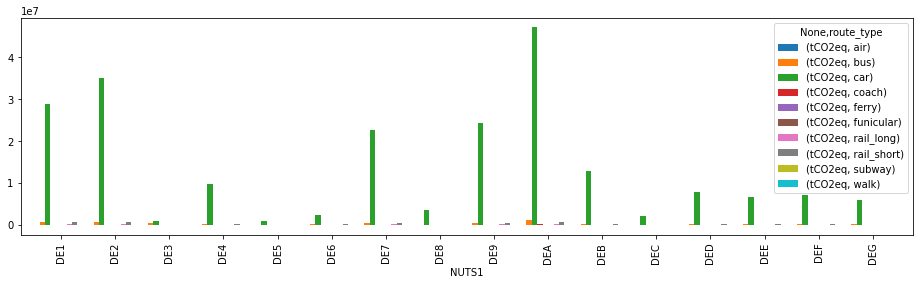

In [33]:
# Emissions by region and mode
all_em.unstack().plot.bar(subplots=False, figsize=(16,4), width=1)

## Save
Create one ecxel output with pkm, emissions, time and cost.

In [34]:
# Load inter-zonal aggregated results
inter = pd.read_excel(output_path + 'inter_zone.xlsx', sheet_name='od', index_col=[0,1,2])
# Get time and price weighted averages by origin and mode
weighted_av = lambda x: np.average(x, weights=inter.loc[x.index, 'volumes'])
inter = inter.groupby(level=[0,2]).agg(
    volumes=('volumes', 'sum'),
    price=('price', weighted_av),
    time=('time', weighted_av))
inter.index.rename(['NUTS1', 'route_type'], inplace=True)

In [35]:
# Sums
for col in ['price', 'time']:
    inter[col] = inter[col] * inter['volumes']
inter.sample()

,,volumes,price,time
NUTS1,route_type,,,
DE5,car,8.726094e+07,5.992194e+08,9.310299e+07


In [36]:
# Merge times
time = inter[['time']].merge(
    (inner['time']*inner['volumes']).rename('time'), how='outer',
    left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
time['time'] = time['time_inter'] + time['time_inner']

In [37]:
# Average car operating hours per day per car
time.xs('car', level=1)['time'].sum() / 46000000 / 365

1.484114086373844

In [38]:
# Merge prices
price = inter[['price']].merge(
    (inner['price']*inner['volumes']).rename('price'), how='outer',
    left_index=True, right_index=True, suffixes=['_inter', '_inner']).fillna(0)
price['price'] = price['price_inter'] + price['price_inner']

In [39]:
# Save excel
with pd.ExcelWriter(output_path + 'results_agg.xlsx') as writer:  
    all_pkm.to_excel(writer, sheet_name='pkm')
    car_vkm.to_excel(writer, sheet_name='car_vkm')
    all_em.to_excel(writer, sheet_name='emissions')
    time.to_excel(writer, sheet_name='time')
    price.to_excel(writer, sheet_name='price')